# OPAN 6609 - Text Analytics
## Final Project

**SAXA 3**
Mike Johnson | Kris Lederer | Sebastian Martinez | Ryan Mathis | Khushi Patel

****

### Set up

In [ ]:
# Import libraries

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Text Analysis
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Load data
df = pd.read_csv('hotel_final.csv')

df.head()

,Unnamed: 0,reviewID,reviewContent,rating,usefulCount,coolCount,funnyCount
0,2982,-ZkzDLAp-6LSdek-nU,My husband took me to stay the night for a fun...,4,0,0,0
1,2983,9yStfyRS5CISu-May43dmA,"stayed at the property over the weekend, got a...",3,0,0,0
2,2984,Wf-7bJszS2n6REXGbrwK2w,"Overall, I think I'm less and less a fan of th...",3,0,0,0
3,2985,ZLe,I'd like to make a confession. I don't really ...,3,21,11,16
4,2986,vURf9AGmThDrRC9TVcQrdw,The good: the view; location The bad: servic...,1,0,0,0


****

### Exploratory Analysis

#### Descriptive Statistics

In [25]:
# Descriptive stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,949.0,19581.200211,89026.260998,2982.0,3990.0,4227.0,4464.0,684983.0
rating,949.0,3.480506,1.199019,1.0,3.0,4.0,4.0,5.0
usefulCount,949.0,0.896733,1.753802,0.0,0.0,0.0,1.0,21.0
coolCount,949.0,0.473130,1.285494,0.0,0.0,0.0,0.0,20.0
funnyCount,949.0,0.378293,1.159802,0.0,0.0,0.0,0.0,16.0


#### Positive vs Negative Ratings

Let's understand the proportion of a positive and negative ratings. For this exercise, categorize ratings into these buckets based on the rating. How we define the categories in `rating_dict`.

In [21]:
# Define positive, negative, neutral conditions
rating_dict = {1: "Negative",
               2: "Negative",
               3: "Negative",
               4: "Positive",
               5: "Positive"}

# Map rating_dict to df
df['rating_category'] = df['rating'].map(rating_dict)

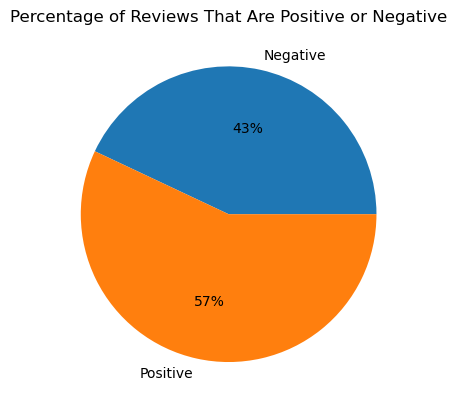

In [23]:
# Summary table rating category
rating_pos_neg = df.groupby(['rating_category']).size().reset_index(name = 'count')
rating_pos_neg['percent_total'] = (rating_pos_neg['count'] / rating_pos_neg['count'].sum()).round(2)

# Visualize Results
plt.pie(rating_pos_neg['percent_total'], labels = rating_pos_neg['rating_category'], autopct = '%1.f%%')
plt.title('Percentage of Reviews That Are Positive or Negative')
plt.show()

Majority of ratings are positive at 57%. However, the proportion of negative reviews at 43% is concerning and worth further exploration.

### N-Grams

Let's take a look at the n-grams to see if there any noticeable high frequency terms.

In [98]:
# Define function to get top n-grams
def top_ngrams(dataframe, text_column, ngram_range=(1,1), additional_stop_words = [], top_n=10):
    """
    Four arguments:
    1. dataframe - input DataFrame
    2. text_column - name of text column  
    3. ngram_range - tuple (min, max) for n-gram range
    4. additional_stop_words - list of any stop words that need to added to the standard stop words list.
    5. top_n - number of top results
    """
    # Extract text from dataframe column
    text_data = dataframe[text_column].tolist()

    # Apply Contraction Expansion
    #text_data = [contractions.fix(text) for text in text_data]

    # Stop words
    combined_stop_words = list(ENGLISH_STOP_WORDS.union(set(additional_stop_words)))
    
    # Instantiate vectorizer
    vectorizer = CountVectorizer(
        ngram_range = ngram_range,
        stop_words = combined_stop_words,
    )
    
    # Vectorize, convert to dense, sum frequencies, sort
    sparse_matrix = vectorizer.fit_transform(text_data)
    dense_matrix = sparse_matrix.toarray()

    # Get feature names (n-grams)
    feature_names = vectorizer.get_feature_names_out()
   
    # Sum the frequencies of the terms across all documents
    term_frequencies = np.sum(dense_matrix, axis=0)

    # Create dataframe with terms and frequencies
    df_ngrams = pd.DataFrame({
        'term': feature_names,
        'frequency': term_frequencies
    })

    # Sort the results by the count (frequency) in descending order
    df_ngrams = df_ngrams.sort_values('frequency', ascending=False)

    # Keep only the top n number of results (n is 10 by default but can be adjusted)
    df_ngrams = df_ngrams.head(top_n)
   
    return df_ngrams

In [85]:
# Define function for n-grams visualization
def ngrams_viz(dataframe, text_column, ngram_range=(1,1), additional_stop_words = [], top_n=10):
    """
    Helpful function for visualizing positive vs negative n-grams.
    Uses top_ngrams() to get the data.

    Four arguments:
    1. dataframe - input DataFrame
    2. text_column - name of text column  
    3. ngram_range - tuple (min, max) for n-gram range
    4. additional_stop_words - list of any stop words that need to added to the standard stop words list.
    5. top_n - number of top results
    """

    # Get positive reviews
    df_positive = top_ngrams(dataframe[dataframe['rating_category'] == 'Positive'], text_column, ngram_range, additional_stop_words, top_n)

    # Get negative reviews
    df_negative = top_ngrams(dataframe[dataframe['rating_category'] == 'Negative'], text_column, ngram_range, additional_stop_words, top_n)

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize positive n-grams on the first subplot (axes[0])
    sns.barplot(x = "frequency", 
                y = "term", 
                data = df_positive,
                ax = axes[0])
    axes[0].set_title(f'Top {top_n} {ngram_range} N-Grams in Positive Reviews')
    axes[0].set_ylabel(f'N-Gram (Range: {ngram_range})')

    # Visualize negative n-grams on the first subplot (axes[1])
    sns.barplot(x = "frequency", 
                y = "term", 
                data = df_negative,
                ax = axes[1])
    axes[1].set_title(f'Top {top_n} {ngram_range} N-Grams in Negative Reviews')
    axes[1].set_ylabel(f'N-Gram (Range: {ngram_range})')

    # Display plot
    plt.tight_layout()
    plt.show()



#### Initial Pass

**Unigrams**

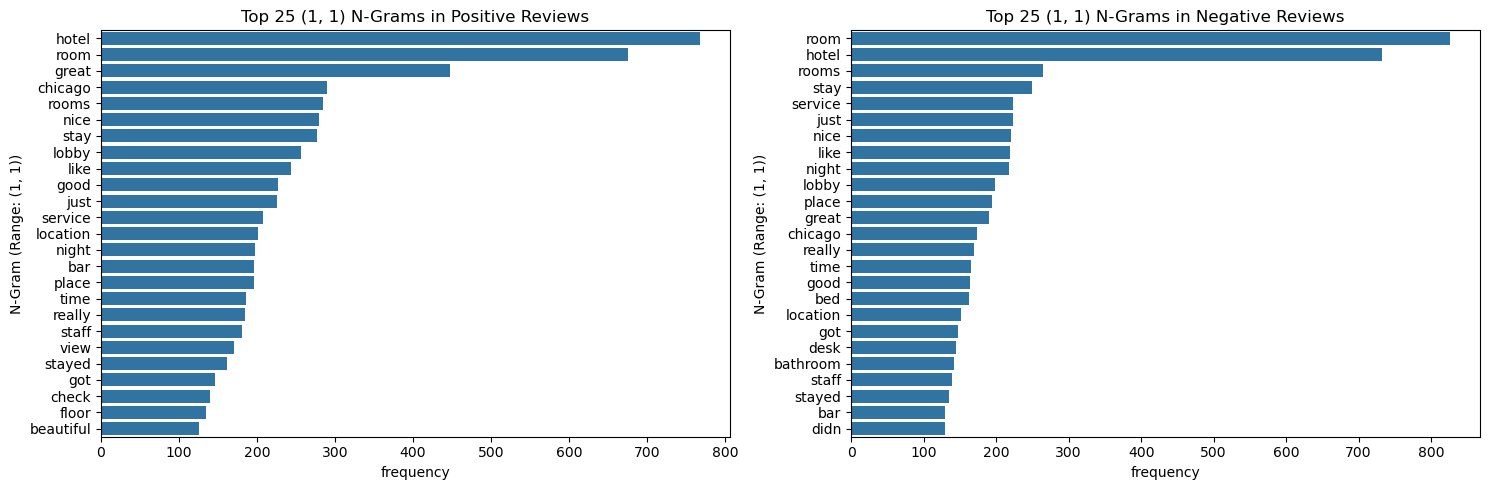

In [99]:
# Get top n grams
ngrams_viz(
    dataframe = df, 
    text_column = 'reviewContent', 
    ngram_range = (1,1), 
    additional_stop_words = [],
    top_n = 25)

**Bigrams**

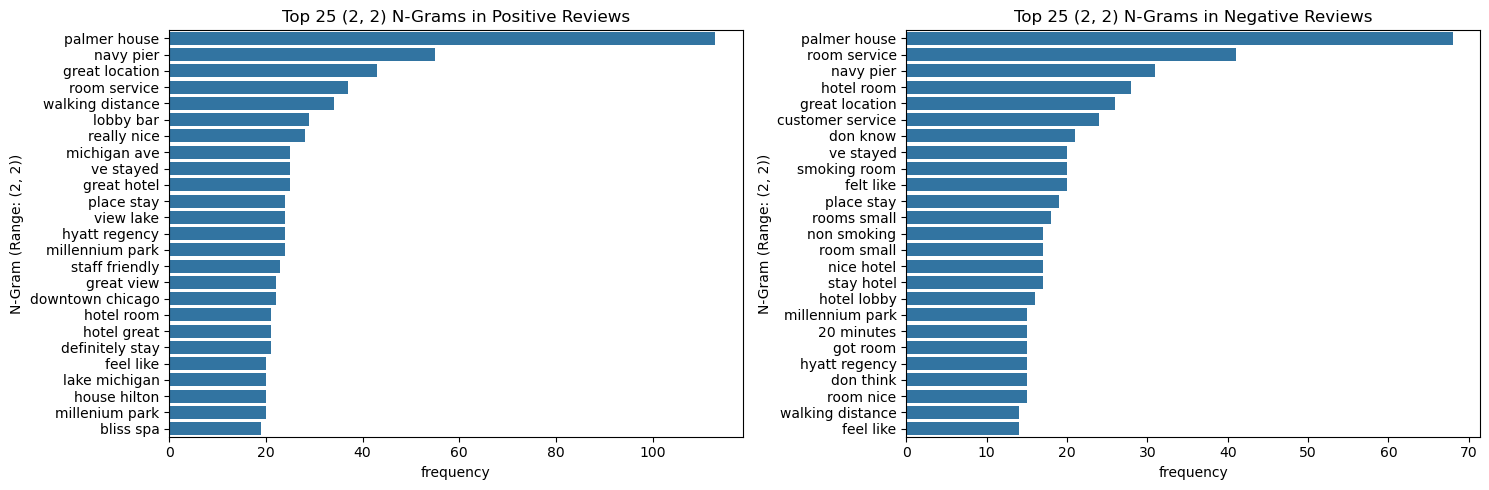

In [100]:
# Get top n grams
ngrams_viz(
    dataframe = df, 
    text_column = 'reviewContent', 
    ngram_range = (2,2), 
    additional_stop_words = [],
    top_n = 25)

**Trigrams**

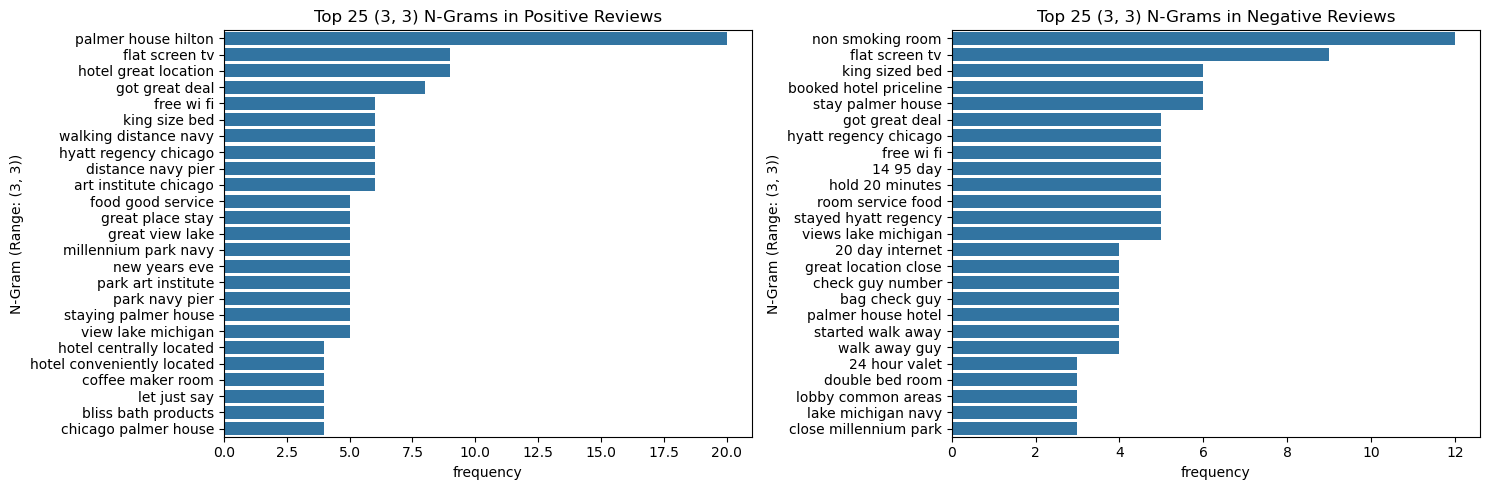

In [101]:
# Get top n grams
ngrams_viz(
    dataframe = df, 
    text_column = 'reviewContent', 
    ngram_range = (3,3), 
    additional_stop_words = [],
    top_n = 25)

**Takeaways**
* Bigrams appears to capture themse best
* Stop words need to be added to remove noise

#### Revised pass with additional stop words

* Remove Chicago.
* Remove Hotel Names. Reviews appear to be for two hotels after further review. Removing the names for both.
* Remove hotel
* Remove miscellaneous stop words

In [107]:
# Define stop words
custom_stop_words = ['chicago', 'palmer', 'house', 'hilton', 'hyatt', 'regency', 'hotel', 'just', 've', 'don']

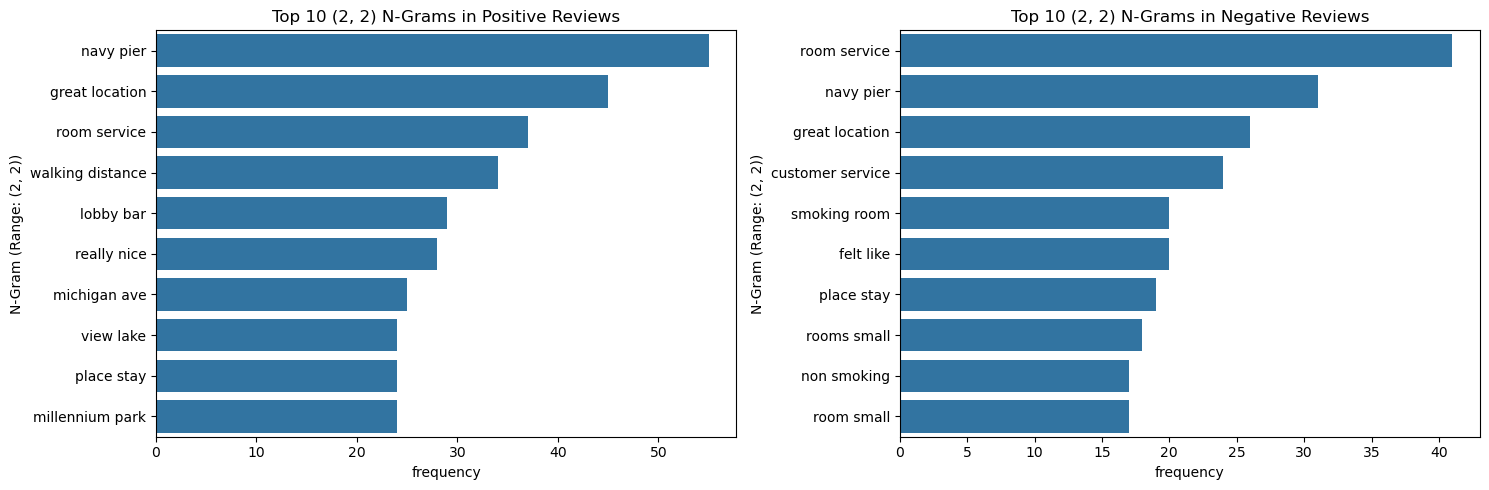

In [110]:
# Get top n grams
ngrams_viz(
    dataframe = df, 
    text_column = 'reviewContent', 
    ngram_range = (2,2), 
    additional_stop_words = custom_stop_words,
    top_n = 10)

The bigrams suggest that the hotel's key strength is its location. The positive reviews make reference to *great location*, *walking distance*, and also make reference to key destinations in Chicago (*Navy Pier*, *Millennium Park*, *Michigan Ave*, *lake*). Even the negative reviews appear to suggest that the location is one of the positive attributes of the hotel despite the negative rating with *great location* and *Navy Pier* being top bigrams as well.

Other observations:
* Positive reviews suggest that the *lobby bar* is a positive attribute.
* Negative reviews suggest *customer service*, *room size* and *smoking* are key areas of frustration.
* Inconsistency in *room service* experience with the bigram appearing in both frequently.

### Apply LDA

In [6]:
# Step 1: Instantiate vectorizer with parameters: vec
vec = CountVectorizer(stop_words = 'english')

# Step 2: Vectorize column of text with fit_transform: X
X = vec.fit_transform(df['reviewContent'])

# Step 3: Instantiate LDA model with parameters: lda
lda = LatentDirichletAllocation(n_components = 2)

# Step 4: Fit LDA model to vectorized text: doc_topics
doc_topics = lda.fit_transform(X)

In [7]:
# Examine topics and words
print(f"There are {lda.components_.shape[0]} topics and {lda.components_.shape[1]}")

There are 2 topics and 8217


****

### Extract Top Words For Each Topic

In [9]:
# Get feature names (vocabulary)
voc = np.array(vec.get_feature_names_out())

In [10]:
# Set number of top words
n_words = 5

# Create a lambda function to remove extract top words from voc
imp_words = lambda x: [voc[each] for each in np.argsort(x)[:-n_words-1:-1]]

In [13]:
# Use imp_words to extract words with the highest weights from our lda model
words_in_topic = ([imp_words(x) for x in lda.components_])

# Join words into single string
main_topics = [' '.join(x) for x in words_in_topic]

# Create dataframe with top words and set index to topic number
main_topics_df = pd.DataFrame({'top_words': main_topics},
                              index = ['Topic_' + str(each) for each in range(lda.n_components)])

In [14]:
# Examine top words
main_topics_df

,top_words
Topic_0,room hotel rooms great chicago
Topic_1,hotel great room good place


****

### Create A Document Topic Matrix From Results

In [15]:
# Set cols and docs to use to create dataframe
cols = ['Topic_' + str(each) for each in range(lda.n_components)]
docs = ['Document_' + str(each) for each in range (X.shape[0])]

# Create dataframe with document proportions in each topic
df_topics = pd.DataFrame(np.round(doc_topics, 2),
                         columns = cols,
                         index = docs)

In [16]:
df_topics

,Topic_0,Topic_1
Document_0,0.18,0.82
Document_1,0.44,0.56
Document_2,0.02,0.98
Document_3,1.00,0.00
Document_4,0.34,0.66
...,...,...
Document_944,0.95,0.05
Document_945,0.37,0.63
Document_946,0.97,0.03
Document_947,0.04,0.96


In [17]:
# Classify each document as topic 0  or topic 1 based on proportion
imp_topic = np.argmax(df_topics.values, axis = 1)

# Create new column called top topic based on classification results
df_topics['top_topic'] = imp_topic

In [18]:
df_topics

,Topic_0,Topic_1,top_topic
Document_0,0.18,0.82,1
Document_1,0.44,0.56,1
Document_2,0.02,0.98,1
Document_3,1.00,0.00,0
Document_4,0.34,0.66,1
...,...,...,...
Document_944,0.95,0.05,0
Document_945,0.37,0.63,1
Document_946,0.97,0.03,0
Document_947,0.04,0.96,1
